```
pip install scikit-learn
```

In [28]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from plotnine import *
import plotnine as p9
import re
from scrapy import Selector
import requests as requests
import json
import statsmodels.api as sm
import spotipy
import base64
from requests import post
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
from sklearn import *

In [2]:
merged_df = pd.read_csv('../data/merged.csv')

In [3]:
def extract_artist_and_song(string):

    pattern_in_brackets = re.compile(r'\[.*?\]')
    pattern_in_parentheses = re.compile(r'\(.*?\)')

    string = re.sub(pattern_in_brackets, '', string)
    string = re.sub(pattern_in_parentheses, '', string)

    if '-' not in string:
        return 'None'
    if '-' in string:
        artist, song = string.split(' - ', 1)

    return [artist.strip(), song.strip()]

In [4]:
new_merge = merged_df

new_merge['Artist'] = merged_df['title'].apply(lambda x: extract_artist_and_song(x)[0])
new_merge['Song'] = merged_df['title'].apply(lambda x: extract_artist_and_song(x)[1])

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories,Artist,Song
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https...",Luis Fonsi,Despacito ft. Daddy Yankee
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https...",Ed Sheeran,Shape of You
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Wiz Khalifa,See You Again ft. Charlie Puth Furious 7 Soun...
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Mark Ronson,Uptown Funk ft. Bruno Mars
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https...",Maroon 5,Sugar


In [5]:
def generate_song_url(song_artist, song_title):
    '''
    Returns a string of the URL for the Genius page of the song

        Parameters:
            song_artist (str): The artist of the song
            song_title (str): The title of the song

        Returns:
            song_url (str): The URL for the Genius page of the song
    '''
    
    base_url = 'https://genius.com/'
    
    # format the artist name and song title
    song_artist = song_artist.replace('&', 'and')
    formatted_artist = song_artist.lower().replace(' ', '-')
    formatted_title = song_title.lower().replace(' ', '-')
    
    # generate the song URL by concatenating strings according to Genius formatting
    song_url = f'{base_url}{formatted_artist}-{formatted_title}-lyrics'

    return song_url

In [6]:
new_merge['Genius_URL'] = new_merge.apply(lambda row: generate_song_url(row['Artist'], row['Song']), axis=1)

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories,Artist,Song,Genius_URL
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https...",Luis Fonsi,Despacito ft. Daddy Yankee,https://genius.com/luis-fonsi-despacito-ft.-da...
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https...",Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Wiz Khalifa,See You Again ft. Charlie Puth Furious 7 Soun...,https://genius.com/wiz-khalifa-see-you-again-f...
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Mark Ronson,Uptown Funk ft. Bruno Mars,https://genius.com/mark-ronson-uptown-funk--ft...
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https...",Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics


In [7]:
def scrape_lyrics(session, song_url):
    '''
    Returns a string of song lyrics, with each line separated by a new line

        Parameters:
            session (variable): The session that has been initialised for requesting from the Genius website
            song_url (str): The URL of the Genius page for the song

        Returns:
            lyrics (str): The lyrics of the song
    '''
    
    # use initialised session to enhance performance
    response = session.get(song_url)
    sel = Selector(text=response.text)
    
    # scrape lyrics into one large string
    raw_lyrics = ' '.join(sel.css('div.Lyrics__Container-sc-1ynbvzw-1.kUgSbL ::text').getall())

    # clean lyrics using regular expression to remove words in square brackets
    pattern = r'\[.*?\]'
    result_string = re.sub(pattern, '', raw_lyrics)
    lyrics = ' '.join(result_string.split())

    return lyrics

In [21]:
credentials_file_path = "../credentials.json"

with open(credentials_file_path, "r") as f:
    credentials = json.load(f)

In [22]:
my_session = requests.Session()

In [26]:
my_session.get('https://genius.com/ed-sheeran-shape-of-you-lyrics')

<Response [403]>

In [23]:
new_merge['lyrics'] = new_merge.apply(lambda row: scrape_lyrics(my_session, row['Genius_URL']), axis=1)

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories,Artist,Song,Genius_URL,lyrics
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https...",Luis Fonsi,Despacito ft. Daddy Yankee,https://genius.com/luis-fonsi-despacito-ft.-da...,
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https...",Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics,
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Wiz Khalifa,See You Again ft. Charlie Puth Furious 7 Soun...,https://genius.com/wiz-khalifa-see-you-again-f...,
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Mark Ronson,Uptown Funk ft. Bruno Mars,https://genius.com/mark-ronson-uptown-funk--ft...,
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https...",Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics,


In [11]:
new_merge2 = new_merge.dropna()

df = new_merge2[['Artist', 'Song', 'like_count', 'view_count', 'comment_count', 'lyrics']].dropna().drop_duplicates(subset = ['Song'])

df = df[df['lyrics'] != '']

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics


In [12]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(lyric):
    scores = sid.polarity_scores(lyric)
    list = [scores['neg'], scores['neu'], scores['pos'], scores['compound']]
    return list

In [13]:
df['sentiment_positive'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[2])
df['sentiment_neutral'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[1])
df['sentiment_negative'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[0])
df['sentiment_compound'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[3])

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound


In [14]:
def get_lexical_richness(lyric):
    total_words = len(lyric.split())
    unique_words = len(set(lyric.split()))
    lexical_richness = unique_words/total_words*100
    return round(lexical_richness)

In [15]:
df['lexical_richness'] = df['lyrics'].apply(lambda x: get_lexical_richness(x))

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness


In [16]:
df['song_length'] = df['lyrics'].apply(lambda x: len(x.split()))

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length


In [17]:
g = p9.ggplot(
    mapping = p9.aes(x = 'sentiment_compound'),
    data = df
) + \
geom_histogram(binwidth=0.05)

g

TypeError: object of type 'NoneType' has no len()

In [ ]:
df['sentiment_compound_absolute'] = df['sentiment_compound'].abs()

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute
1,Ed Sheeran,Shape of You,32320240,6148732491,1146075,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23,699,0.9995
4,Maroon 5,Sugar,15906116,3972473469,418271,"I'm hurting, baby, I'm broken down I need your...",0.289,0.642,0.070,0.9988,29,472,0.9988
5,OneRepublic,Counting Stars,17489708,3926960087,488655,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21,517,0.9831
6,Katy Perry,Roar,16594997,3918320627,774303,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31,352,0.9945
8,Justin Bieber,Sorry,16305640,3741329014,868531,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35,359,0.9039


In [ ]:
corr_df = df[['like_count','view_count','comment_count', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sentiment_compound_absolute', 'lexical_richness', 'song_length']].corr()

In [ ]:
corr_df2 = corr_df. \
        melt(ignore_index=False) \
        .reset_index()

corr_df2['rounded_value'] = corr_df2['value'].apply(lambda x: np.round(x, 2))

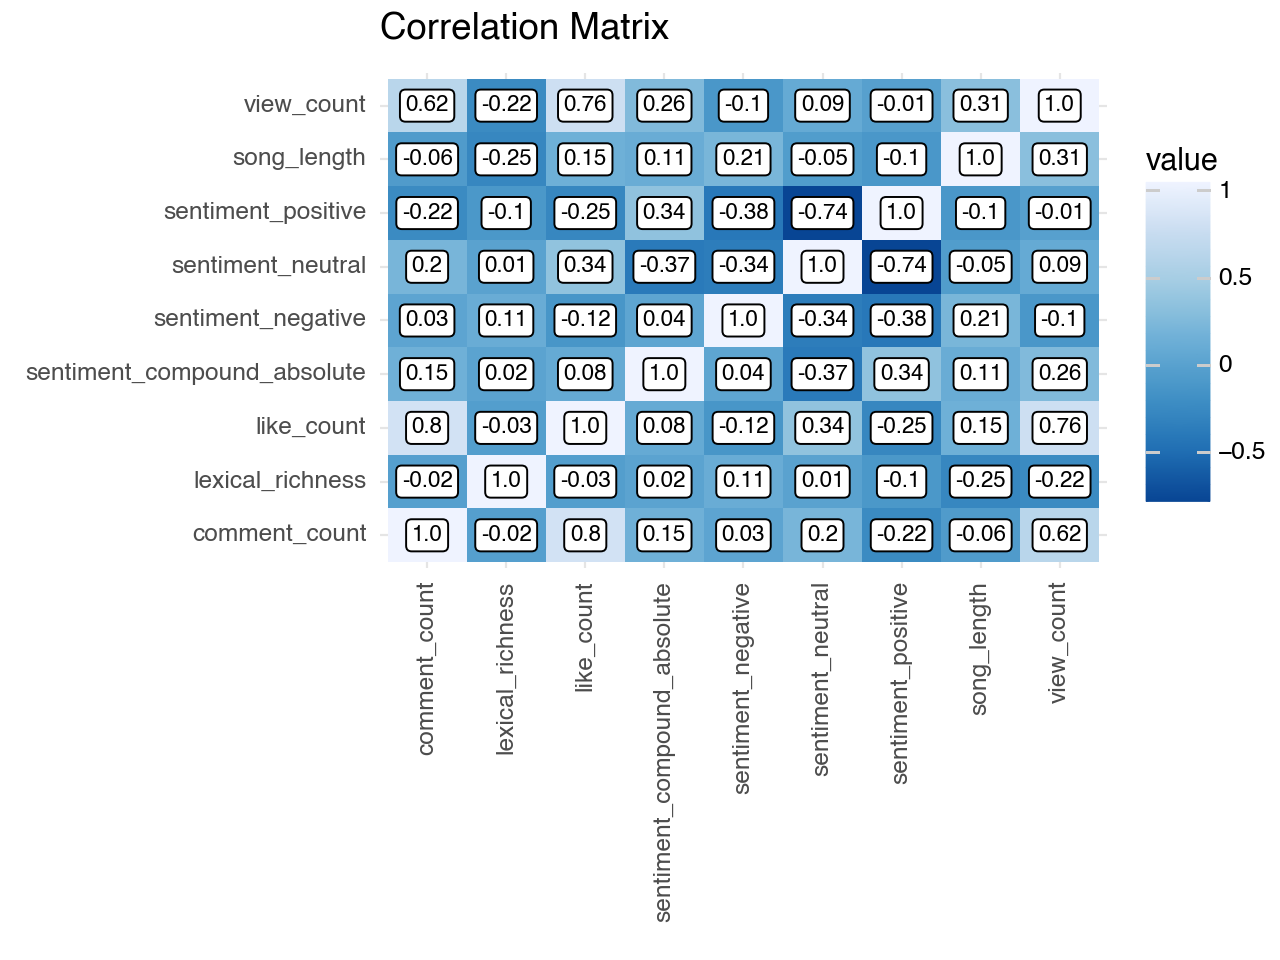

<Figure Size: (640 x 480)>

In [ ]:
g = p9.ggplot(
        mapping = p9.aes('index', 'variable', fill = 'value'),
        data = corr_df2
    ) + \
        p9.geom_tile() + \
        p9.geom_label(
            p9.aes(label = 'rounded_value'),
            fill = 'white',
            size = 8
        ) + \
        p9.scale_fill_distiller() + \
        p9.theme_minimal() + \
        p9.labs(
            title = 'Correlation Matrix',
            x = '',
            y = ''
        ) + \
        p9.theme(
            axis_text_x = element_text(angle = 90)
        )

g

In [ ]:
X = df[['view_count', 'comment_count', 'lexical_richness', 'sentiment_compound_absolute', 'song_length']]
Y = df['like_count']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     15.93
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           8.21e-07
Time:                        22:18:19   Log-Likelihood:                -466.87
No. Observations:                  29   AIC:                             945.7
Df Residuals:                      23   BIC:                             953.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

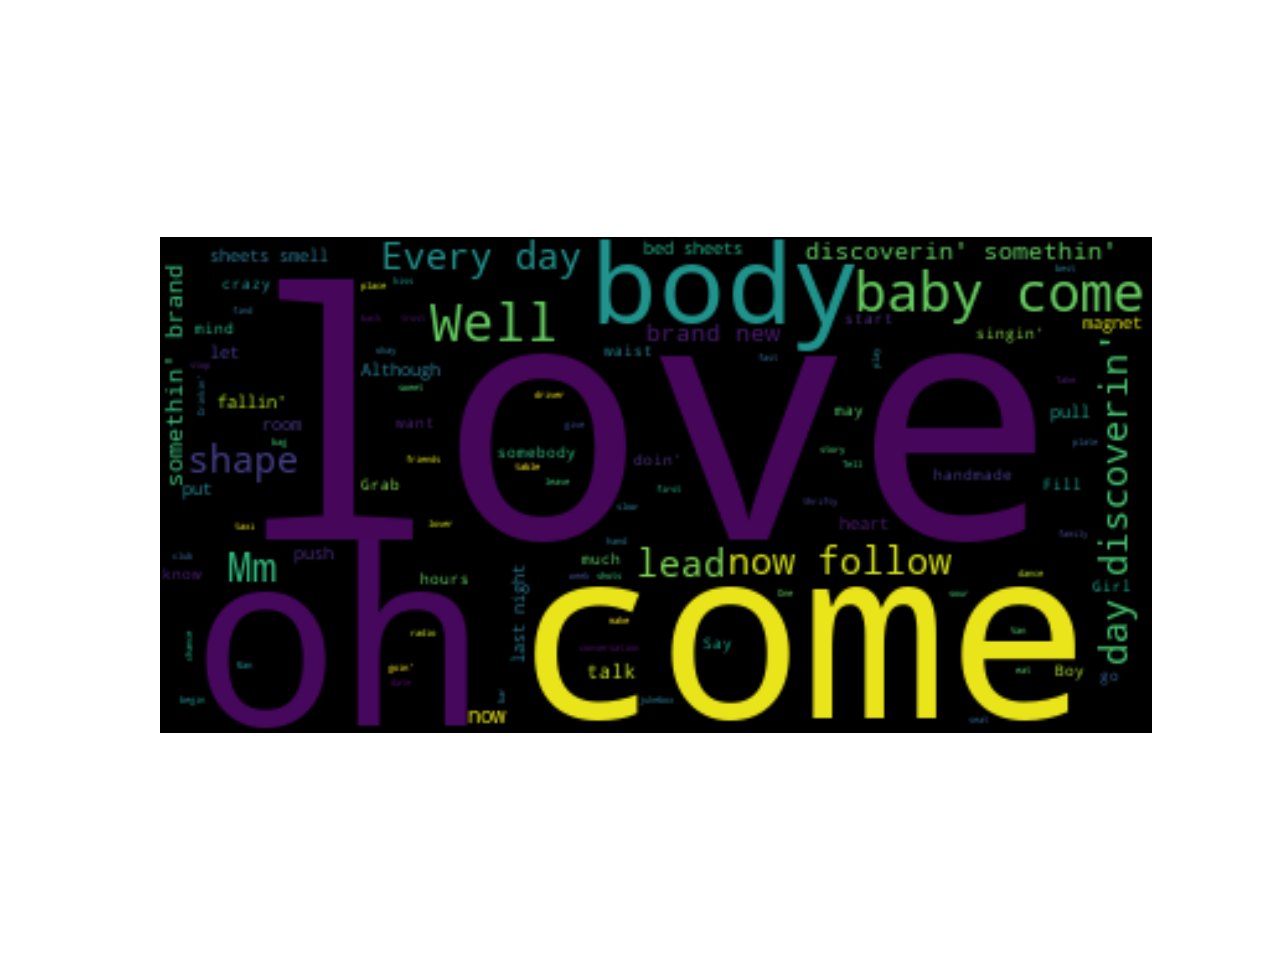

In [ ]:
wordcloud = WordCloud().generate(df.iloc[0,5])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
credentials_file = "../credentials_spotify.json"

with open(credentials_file, "r") as f:
    spotify_credentials = json.load(f)

In [ ]:
client_id = spotify_credentials['client_id']
client_secret = spotify_credentials['client_secret']

client_creds = f"{client_id}:{client_secret}"
base64_client_creds = b64encode(client_creds.encode()).decode()

auth_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {base64_client_creds}'
}
payload = {
    'grant_type': 'client_credentials'
}

response = requests.post(auth_url, headers=headers, data=payload)

response.json()


{'access_token': 'BQCw5GuwrWtZyMELOygHiJVWd7xYPioODwn7cin_EWENI8YtfPGOqvuOgBt48T-y-sBnVLJ_SgwzEKnB80HsX2K9ofg0EXNEEV_z_Z4wEX9lUT96oFA',
 'token_type': 'Bearer',
 'expires_in': 3600}

In [ ]:
def get_release_date(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    release_date = result['tracks']['items'][0]['album']['release_date']
    return release_date

'2017-03-03'

In [ ]:
def get_popularity(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    popularity = result['tracks']['items'][0]['popularity']
    return popularity

88

In [ ]:
def get_explicitness(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    explicitness = result['tracks']['items'][0]['explicit']
    return explicitness

False

In [13]:
new_df = pd.read_csv('./DS105/Group_Project_8Dec/ds105a-project-dees-nuts/data/for_ruikai.csv')

new_df

,Unnamed: 0,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute
0,1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23,699,0.9995
1,4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.289,0.642,0.070,0.9988,29,472,0.9988
2,5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21,517,0.9831
3,6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31,352,0.9945
4,8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35,359,0.9039
5,9,Ed Sheeran,Thinking Out Loud,14912750,3699993663,372173,When your legs don't work like they used to be...,0.188,0.789,0.023,0.9967,44,326,0.9967
6,11,Ed Sheeran,Perfect,20501323,3611596720,508475,"I found a love for me Oh, darlin', just dive r...",0.251,0.700,0.049,0.9974,52,297,0.9974
7,12,Alan Walker,Faded,27565139,3555488824,1264810,You were the shadow to my light Did you feel u...,0.041,0.883,0.076,-0.8263,44,179,0.8263
8,15,Taylor Swift,Shake It Off,13070777,3373072126,574307,I stay out too late Got nothin' in my brain Th...,0.101,0.470,0.429,-0.9997,27,557,0.9997
9,16,Taylor Swift,Blank Space,15193621,3319525781,641033,"Nice to meet you, where you been? I could show...",0.158,0.662,0.181,-0.8890,40,519,0.8890


In [32]:
data = new_df[['view_count', 'comment_count', 'lexical_richness', 'sentiment_compound_absolute', 'song_length', 'like_count']]
Y = new_df['like_count']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.115e+26
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          1.18e-266
Time:                        21:44:22   Log-Likelihood:                 350.56
No. Observations:                  28   AIC:                            -687.1
Df Residuals:                      21   BIC:                            -677.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [22]:
from scipy.stats import zscore
zetascore_table=zscore(X,axis=0)

zetascore_table

,const,view_count,comment_count,lexical_richness,sentiment_compound_absolute,song_length,like_count
0,NaN,3.405457,2.378102,-1.481517,0.499974,2.108435,3.338607
1,NaN,1.132351,-0.549363,-0.686326,0.497140,0.470145,0.047849
2,NaN,1.084909,-0.266139,-1.746580,0.433565,0.794916,0.365367
3,NaN,1.075844,0.882631,-0.421262,0.479728,-0.395912,0.185948
4,NaN,0.890930,1.261609,0.108865,0.112860,-0.345392,0.127985
5,NaN,0.847530,-0.734850,1.301652,0.488636,-0.583557,-0.151439
6,NaN,0.755208,-0.186630,2.361907,0.491471,-0.792854,0.968823
7,NaN,0.696608,2.855420,1.301652,-0.201366,-1.644476,2.384806
8,NaN,0.506090,0.078152,-0.951389,0.500784,1.083602,-0.520674
9,NaN,0.450166,0.346530,0.771525,0.052525,0.809350,-0.095137


In [23]:
min(zetascore_table)

'comment_count'

In [24]:
xx = zetascore_table[['view_count', 'comment_count', 'lexical_richness', 'sentiment_compound_absolute', 'song_length']]
Y = zetascore_table['like_count']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.262e+24
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          3.23e-246
Time:                        21:32:02   Log-Likelihood:                 719.66
No. Observations:                  28   AIC:                            -1425.
Df Residuals:                      21   BIC:                            -1416.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Assume you have a DataFrame named 'data' with columns 'Var1', 'Var2', 'Var3', ... containing your variables

# Step 1: Normalization using Min-Max Scaling
scaler = MinMaxScaler()  # Create an instance of MinMaxScaler
scaled_data = scaler.fit_transform(data)  # Fit and transform the data

# Convert the scaled data back to a DataFrame for readability (optional)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

# Step 2: Running Linear Regression
# Assuming 'target' is the column you want to predict, and 'features' are the predictors
target = 'like_count'
features = ['view_count', 'comment_count', 'lexical_richness', 'sentiment_compound_absolute', 'song_length']  # Update with your column names

X = scaled_df[features]  # Independent variables
y = scaled_df[target]  # Dependent variable

# Create an instance of the Linear Regression model
model = LinearRegression()

# Fit the model with the scaled data
model.fit(X, y)

# Obtain coefficients (slope) and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [ 0.43154572  0.44721425  0.10133512 -0.11432041  0.07863538]
Intercept: 0.09069585295512422
